# Dataset Validation with Clustering and Nearest Neighbors

In [1]:
from pprint import pprint
from sklearn.feature_extraction.text import HashingVectorizer, TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import adjusted_rand_score, homogeneity_completeness_v_measure
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics.pairwise import cosine_distances
from scipy import sparse
from hdbscan import HDBSCAN
from collections import defaultdict, Counter
from sentence_transformers import SentenceTransformer, util
import numpy as np

In [2]:
def read_event_dataset(path):
    with open(path) as f:
        dataset = []
        for line in list(f)[1:]:
            id, text, label = line.strip().split("\t")
            item = {
                "id": id, "text": text, "label": label
            }
            dataset.append(item)
    return dataset

### Load Dataset

In [3]:
path = "/home/demian/Downloads/test_set_final_release_with_labels.tsv"
dataset = read_event_dataset(path)
texts = [x["text"] for x in dataset]
true_labels = [x["label"] for x in dataset]
label_names = sorted(set(true_labels))

In [4]:
Counter(true_labels)

Counter({'AIR_STRIKE': 36,
         'NATURAL_DISASTER': 37,
         'FORCE_AGAINST_PROTEST': 23,
         'NON_STATE_ACTOR_OVERTAKES_TER': 24,
         'AGREEMENT': 31,
         'CHEM_WEAP': 37,
         'PEACE_PROTEST': 57,
         'GOV_REGAINS_TERIT': 38,
         'DISR_WEAP': 58,
         'PROPERTY_DISTRUCT': 21,
         'OTHER': 8,
         'CHANGE_TO_GROUP_ACT': 30,
         'GRENADE': 48,
         'VIOL_DEMONSTR': 53,
         'MAN_MADE_DISASTER': 52,
         'ATTRIB': 28,
         'MOB_VIOL': 17,
         'ATTACK': 27,
         'ARMED_CLASH': 66,
         'ART_MISS_ATTACK': 36,
         'NON_VIOL_TERRIT_TRANSFER': 21,
         'PROTEST_WITH_INTER': 22,
         'DIPLO': 44,
         'SUIC_BOMB': 41,
         'ARREST': 34,
         'REM_EXPLOS': 36,
         'SEX_VIOL': 23,
         'ORG_CRIME': 29,
         'ABDUCT_DISSAP': 20,
         'HQ_ESTABLISHED': 22})

## Encode dataset with different vectorizers

We experiment with the following vectorizers
* `HashingVectorizer`
* `TfidfVectorizer`
* `sentence-transformers`

These models are of increasing complexity: while `HashingVectorizer` is a fast, stateless method, the transformer-based encoders from `sentence-transformers` require large pretrained models. We will compare these vectorizers based on how well they represent the dataset w.r.t to the provided ground-truth labels. This will help us to see whether the dataset is "easy" or "difficult", and whether simple fast approaches have are likely to be successful.

In [5]:
hv_vectors = HashingVectorizer(n_features=1000).fit_transform(texts)

In [6]:
tfidf_vectors = TfidfVectorizer().fit_transform(texts)

In [7]:
model = SentenceTransformer("stsb-mpnet-base-v2")
st_vectors = model.encode(texts)
st_vectors = np.float64(st_vectors)

/home/demian/anaconda3/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


# 1. Clustering Analysis

At first we check how well unsupervised clustering can recover the ground-truth labels for each vectorizer.

In [8]:
def labels_to_clusters(items, labels, noise_label=-1):
    label_to_items = defaultdict(list)
    for i, l in enumerate(labels):
        label_to_items[l].append(items[i])
    clusters = []

    for l, items in label_to_items.items():
        if l == noise_label:
            clusters += [[x] for x in items]
        else:
            clusters.append(items)
    clusters.sort(key=len, reverse=True)
    return clusters


def run_clustering(clusterer, vectors, items):
    distances = cosine_distances(vectors)
    labels = clusterer.fit_predict(distances)
    clusters = labels_to_clusters(items, labels)
    return clusters, labels


def evaluate_clustering(true_labels, pred_labels):    
    ari = adjusted_rand_score(true_labels, pred_labels)
    h, c, v = homogeneity_completeness_v_measure(true_labels, pred_labels)
    print(f"adjusted rand index: {ari:.6f}")
    print(f"homogeneity: {h:.3f}")
    print(f"completeness: {c:.3f}")
    print(f"v-measure: {v:.3f}")

In [9]:
hdbscan_clusterer = HDBSCAN(min_cluster_size=5, metric="precomputed")

In [10]:
kmeans_clusterer = KMeans(n_clusters=len(label_names))

In [11]:
# hv_clusters, hv_labels = run_clustering(hdbscan_clusterer, hv_vectors, texts)
# tfidf_clusters, tfidf_labels = run_clustering(hdbscan_clusterer, tfidf_vectors, texts)
# st_clusters, st_labels = run_clustering(hdbscan_clusterer, st_vectors, texts)

In [12]:
hv_clusters, hv_labels = run_clustering(kmeans_clusterer, hv_vectors, texts)
tfidf_clusters, tfidf_labels = run_clustering(kmeans_clusterer, tfidf_vectors, texts)
st_clusters, st_labels = run_clustering(kmeans_clusterer, st_vectors, texts)

### Evaluating clusters

We evaluate the different clustering results with the adjusted rand index (ARI) and with homogeneity, completeness and v-measure.

In [13]:
print("-- Hashing vectorizer --")
evaluate_clustering(true_labels, hv_labels)
print("\n-- TFIDF vectorizer --")
evaluate_clustering(true_labels, tfidf_labels)
print("\n-- Sentence transformers --")
evaluate_clustering(true_labels, st_labels)

-- Hashing vectorizer --
adjusted rand index: 0.013075
homogeneity: 0.183
completeness: 0.181
v-measure: 0.182

-- TFIDF vectorizer --
adjusted rand index: 0.118188
homogeneity: 0.380
completeness: 0.403
v-measure: 0.391

-- Sentence transformers --
adjusted rand index: 0.333748
homogeneity: 0.606
completeness: 0.598
v-measure: 0.602


The vectors produced by `sentence-transformers` are far better than the simple sparse vectorizers. However there is also a big difference between `TFIDFVectorizer` which uses learned word weights and the stateless `HashingVectorizer`.

# 2. Visualizing Vectors

Below we will project the different vectors into low-dimensional embeddings and plot these. "Good" vectors will be visible as well-separated points in a plot corresponding to the ground-truth labels while "bad" vectors will be all over the place.

In [14]:
import umap
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D


def visualize_vectors(vectors, true_labels, label_names, make_legend=False):
    #reducer = umap.UMAP(n_components=3)
    reducer = umap.UMAP()
    embeddings = reducer.fit_transform(vectors)
    
    num_to_color = sns.color_palette("Spectral", n_colors=len(label_names))
    label_to_num = dict((l, i) for i, l in enumerate(label_names))
    data_colors = [num_to_color[label_to_num[l]] for l in true_labels]
    label_colors = [num_to_color[label_to_num[l]] for l in label_names]
    
    scatter = plt.scatter(
        embeddings[:, 0],
        embeddings[:, 1],
        c=data_colors,
        marker="o",     
    )
    plt.gca().set_aspect('equal', 'datalim')
    plt.title('UMAP projection of vectors', fontsize=15)
    
    if make_legend:
        legend_elements = [
                   Line2D([0], [0], marker='o', color='w', label=l,
                          markerfacecolor=num_to_color[num], markersize=15)
                   for l, num in label_to_num.items()
        ]                
        plt.legend(handles=legend_elements)
    plt.rcParams['figure.figsize'] = [5, 5]

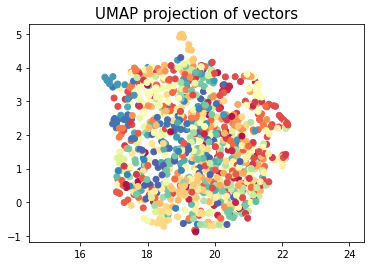

In [15]:
visualize_vectors(hv_vectors, true_labels, label_names)

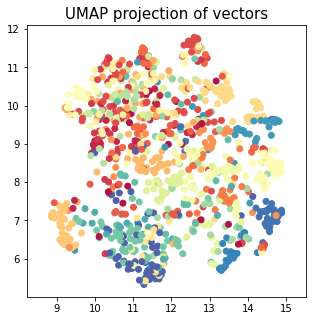

In [16]:
visualize_vectors(tfidf_vectors, true_labels, label_names)

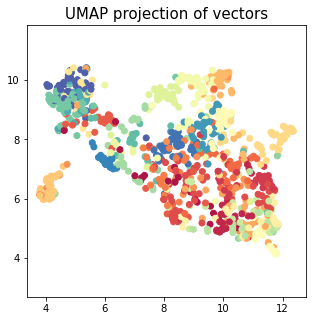

In [17]:
visualize_vectors(st_vectors, true_labels, label_names)

These plots tell us the same story as the clustering analysis:
* `HashingVectorizer` does a poor job at encoding this dataset related to the true labels while `sentence-transformers` performs best.
* The latter is not perfect: many items of different classes are close in vector space.

### Visualization for subset of labels

Let's look at a small selection of labels in particular.

In [18]:
subset_label_names = ["ARREST", "ATTACK", "DIPLO", "PEACE_PROTEST", "VIOL_DEMONSTR"]
subset_indices = [i for i in range(len(dataset)) if true_labels[i] in subset_label_names]
subset_true_labels = [true_labels[i] for i in subset_indices]
subset_hv_vectors = sparse.vstack([hv_vectors[i] for i in subset_indices])
subset_tfidf_vectors = sparse.vstack([tfidf_vectors[i] for i in subset_indices])
subset_st_vectors = np.stack([st_vectors[i] for i in subset_indices])

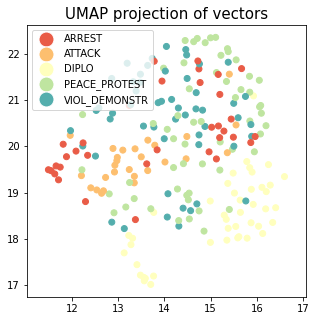

In [19]:
visualize_vectors(subset_hv_vectors, subset_true_labels, subset_label_names, make_legend=True)

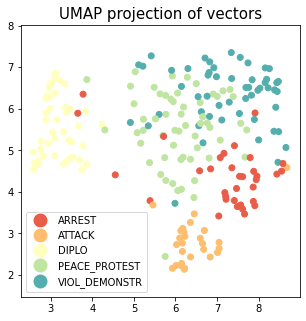

In [20]:
visualize_vectors(subset_tfidf_vectors, subset_true_labels, subset_label_names, make_legend=True)

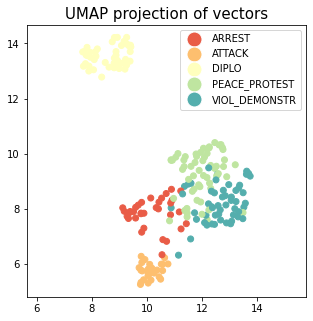

In [21]:
visualize_vectors(subset_st_vectors, subset_true_labels, subset_label_names, make_legend=True)

## 3. Nearest-Neighbor Analysis

Below we inspect whether the nearest neighbor of an item -- according to a specific vectorizer -- has the same label as the item. 

In [22]:
from scipy import sparse
from sklearn.neighbors import kneighbors_graph


def evaluate_nearest_neighbors(items, vectors, k=1):
    similarity = cosine_similarity(vectors, vectors)
    g = kneighbors_graph(similarity, k, mode='connectivity', include_self=False)
    neighbor_data = defaultdict(list)
    cx = sparse.coo_matrix(g)
    for i,j,v in zip(cx.row, cx.col, cx.data):
        neighbor_data[i].append((j, v))
    results = []
    for i, item in enumerate(items):        
        label = item["label"]
        nns = sorted(neighbor_data[i], key=lambda x: x[1], reverse=True)
        nn_labels = [items[j]["label"] for j, _ in nns]        
        result = 1 if label in nn_labels else 0
        results.append(result)
    return np.mean(results)            

In [23]:
evaluate_nearest_neighbors(dataset, hv_vectors, k=1)

0.20510304219823355

In [24]:
evaluate_nearest_neighbors(dataset, tfidf_vectors, k=1)

0.5819430814524044

In [25]:
evaluate_nearest_neighbors(dataset, st_vectors, k=1)

0.6329735034347399

This result means that e.g. the nearest neighbor of 63% of the items in the transformer-based vector space have the same label as the item. Interestingly, `TFIDF-Vectorizer` is not far off.
